See here: https://github.com/fchollet/keras/issues/1061

In [32]:
# %load gmm.py
"""
See here: https://github.com/fchollet/keras/issues/1061
"""
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Layer
from keras.optimizers import SGD

### load data
from imp import reload
import site; site.addsitedir('..')
import mylib.data as md
reload(md)

df, dfd = md.iris()

y_cols = ['petal length (cm)']
x_cols = [x for x in dfd.columns if x not in y_cols]

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfd[x_cols].values,
        dfd[y_cols].values, test_size=0.1)

input_dim = X_train.shape[1]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Layer
from keras.optimizers import SGD
from theano import tensor as T
import theano

class GMMActivation(Layer):
    """
    GMM-like activation function.
    Assumes that input has (D+2)*M dimensions, where D is the dimensionality of the
    target data. The first M*D features are treated as means, the next M features as
    standard devs and the last M features as mixture components of the GMM.
    """
    def __init__(self, M, D, **kwargs):
        super(GMMActivation, self).__init__(**kwargs)
        self.M = M
        self.D = D

    def get_output(self, train=False):
      X = self.get_input(train)
      # D = T.shape(X)[1]/self.M - 2
      # leave mu values as they are since they're unconstrained
      # scale sigmas with exp, s.t. all values are non-negative
      X = T.set_subtensor(X[:,D*self.M:(D+1)*self.M], T.exp(X[:,D*self.M:(D+1)*self.M]))
      # scale alphas with softmax, s.t. that all values are between [0,1] and sum up to 1
      X = T.set_subtensor(X[:,(D+1)*self.M:(D+2)*self.M], T.nnet.softmax(X[:,(D+1)*self.M:(D+2)*self.M]))
      return X

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "M": self.M}
        base_config = super(GMMActivation, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def gmm_loss_factory(M, D):
    def gmm_loss(y_true, y_pred):
      """
      GMM loss function.
      Assumes that y_pred has (D+2)*M dimensions and y_true has D dimensions. The first
      M*D features are treated as means, the next M features as standard devs and the last
      M features as mixture components of the GMM.
      """
      def loss(m, M, D, y_true, y_pred):
        mu = y_pred[:,D*m:(m+1)*D]
        sigma = y_pred[:,D*M+m]
        alpha = y_pred[:,(D+1)*M+m]
        return (alpha/sigma) * T.exp(-T.sum(T.sqr(mu-y_true),-1)/(2*sigma**2))

      # D = T.shape(y_true)[1]
      # M = T.shape(y_pred)[1]/(D+2)
      seq = T.arange(M)
      result, _ = theano.scan(fn=loss, outputs_info=None,
        sequences=seq, non_sequences=[M, D, y_true, y_pred])
      return -T.log(result.sum(0))
    return gmm_loss

M = 3
D = y_train.shape[1]
gmm_loss = gmm_loss_factory(M, D)
model_gmm = Sequential()
model_gmm.add(Dense(input_dim=input_dim, output_dim=(input_dim + 2) * M))
model_gmm.add(GMMActivation(M, D))

sgd = SGD(lr=0.0025, decay=1e-6, momentum=0.5, nesterov=True)

# model_gmm.compile(loss=gmm_loss, optimizer='adam')
model_gmm.compile(loss=gmm_loss, optimizer=sgd)

(135, 6) (135, 1) (15, 6) (15, 1)


In [33]:
X_train.shape, y_train.shape

((135, 6), (135, 1))

In [36]:
out = model_gmm.fit(X_train, y_train, nb_epoch=100, batch_size=30, validation_data=(X_test, y_test), show_accuracy=True)

Train on 135 samples, validate on 15 samples
Epoch 1/100
135/135 [==============================] - 0s - loss: 1.9835 - acc: 0.3037 - val_loss: 1.4745 - val_acc: 0.4000
Epoch 2/100
135/135 [==============================] - 0s - loss: 1.7667 - acc: 0.4148 - val_loss: 1.4519 - val_acc: 0.4000
Epoch 3/100
135/135 [==============================] - 0s - loss: 1.7011 - acc: 0.4593 - val_loss: 2.0939 - val_acc: 0.6000
Epoch 4/100
135/135 [==============================] - 0s - loss: 1.9374 - acc: 0.8444 - val_loss: 2.0297 - val_acc: 0.8667
Epoch 5/100
135/135 [==============================] - 0s - loss: 1.9580 - acc: 0.9407 - val_loss: 1.9354 - val_acc: 1.0000
Epoch 6/100
135/135 [==============================] - 0s - loss: 1.8643 - acc: 0.9926 - val_loss: 1.8438 - val_acc: 1.0000
Epoch 7/100
135/135 [==============================] - 0s - loss: 1.7716 - acc: 1.0000 - val_loss: 1.7509 - val_acc: 1.0000
Epoch 8/100
135/135 [==============================] - 0s - loss: 1.6768 - acc: 1.0000 

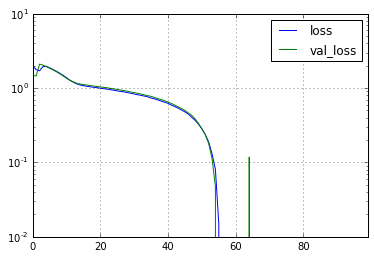

In [38]:
%matplotlib inline
h = pandas.DataFrame(out.history)
h[['loss', 'val_loss']].plot(logy=True)
grid()

In [40]:
p = model_gmm.predict(X_train)

In [41]:
p.shape

(135, 24)